# 1. Rectification

The template below first asks the user to upload three files: an image (`IMAGE`) and two point files (`SOURCE_POINTS_FILE` and `TARGET_POINTS_FILE`).
The point files must be in the form
```
    X1 Y1
    X2 Y2
    X3 Y3
    X4 Y4
```
to define four 2D points.

The `rectify()` below maps the image region defined by the four corners from `SOURCE_POINTS_FILE` to the new region defined by `TARGET_POINTS_FILE`, using the functions
* `build_A()`,
* `compute_H()`,
* `bilinear_interp()`, and
* `warp_homography()`.

Complete these functions in the code cells below, and run Step1-1 to Step1-4. These steps simply do
1. Upload an image file as `IMAGE`, (use "laptop.jpg" for testing)
2. Upload an text file as `SOURCE_POINTS_FILE`, (use "laptop_screen.txt" for testing)
3. Upload an text file as `TARGET_POINTS_FILE`, and (use "laptop_rect.txt" for testing)
4. Run `rectify()` and show the output image.


# 새 섹션

In [0]:
import numpy as np

debug = True

def blah(str):
    if debug:
        print(str)
        
"""build_A ((np.array of n * 2, np.array of n * 2) -> (np.array of 2n * 9))
   pts1: ndarray. Each row is XY coordinate of source points.
   pts2: ndarray. Each row is XY coordinate of target points.

   A helper function of 'compute_H'.
   Constructs the intermediate matrix A used in the computation of an
   homography mapping pts1 to pts2.
"""
def build_A(pts1, pts2):
    #row and column counts
    rc, cc = pts1.shape
    
    p1, p2 = (pts1.tolist(), pts2.tolist()) # for speed
    #Append() of list is faster than np.concatenate
    A = []
    
    '''For each pts1-pts2 pair, following rows are pushed to A.:

       [x y 1 0 0 0 -(x'x) -(x'y) -x']
       [0 0 0 x y 1 -(y'x) -(y'x) -y']

       where (x, y) is a coordinate in pts1 and 
       (x', y') is a coordinate in pts2. 
    '''
    for i in range(0, rc):   
        p2x, p2y = (p2[i][0], p2[i][1])
        zeros = [0,0,0]
        #Cartesian -> Euclidian
        xy1 = p1[i] + [1]
        
        xi= xy1 + zeros + [e * -(p2x) for e in xy1]
        yi= zeros + xy1 + [e * -(p2y) for e in xy1]
        
        A.append(xi)
        A.append(yi)    
    
    return np.array(A) #into np.array



In [0]:
"""compute_H ((np.array of n * 2, np.array of n * 2) -> (np.array of 3 * 3))
   pts1: ndarray. Each row is XY coordinate of source points.
   pts2: ndarray. Each row is XY coordinate of target points.

   Computes an homography mapping one set of co-planar points (pts1) to another (pts2).
   The output of this function is 3*3 homography matrix H.
   H(source point) = target point. 
"""
def compute_H(pts1, pts2):
    # Construct the intermediate A matrix.
    A = build_A(pts1, pts2)
    
    # Compute the symmetric matrix AtA.
    AtA = np.transpose(A).dot(A)

    # Compute the eigenvalues and eigenvectors of AtA.
    e_val, e_vec = np.linalg.eig(AtA)
    e_val = np.absolute(e_val)
    mindex = np.argmin(e_val)
    return_v = e_vec[:,mindex] #weird indexing system
    
    # Return the eigenvector corresponding to the smallest eigenvalue, 
    # reshaped as a 3x3 matrix.
    return return_v.reshape(3,3)
    
    

    


In [0]:
"""
   image: Pre-warp original image (n*m*3 or n*m*1 if greyscale)
   points: ndarray of (i*j*2). points[i,j] contains a XY coordinate
           of the aforementioned source image, which can be used to 
           get a pixel of the source image. 

   Looks up the pixel values in an image at a given point using bilinear
   interpolation. The coordinates (x,y) in 'points', however,
   are real numbers, rendering pixel retrieval by array lookup (image[y][x]) impossible.
   
   To get around this issue, we drop the fractionals(to turn them into int) 
   and perform bilinear interpolation to moderate pixelation. 

"""
def bilinear_interp(image, points):
    y_border, x_border, c_channel = image.shape 

    if (c_channel == 1): #Greyscale
        blah("Greyscale.")
    else:
        blah("Vibrant c o l o r s !")

    y_size, x_size = points.shape[0:2]
    poINTs = points.astype(int)   
    Fxy = np.zeros((y_size, x_size, c_channel))

    #weight arrays (for a and b)
    a, b = np.split(points - poINTs, 2,  axis=2)
    a_in, b_in = (np.ones(a.shape) - a, np.ones(b.shape) - b)  # 1-a, 1-b.

    flattened = poINTs.reshape(-1, 2)
    flattened_x = flattened[:, 0]
    flattened_y = flattened[:, 1]
    blah("shape of flattened(Pre-Mask)")
    blah(flattened_x.shape)
    blah(flattened_y.shape)

    mask = (flattened_x >= 0) * (flattened_y >= 0) * (flattened_x < x_border - 1) * (flattened_y < y_border - 1)
    blah("mask")
    blah(mask)
    blah(mask.shape)

    y_coords, x_coords = np.meshgrid(np.arange(y_size), np.arange(x_size))
    y_coords = y_coords.T.reshape(-1)[mask]
    x_coords = x_coords.T.reshape(-1)[mask]
    blah("shape of x/y coordinates")
    blah(x_coords.shape)
    blah(y_coords.shape)

    flattened_y = flattened_y[mask]
    flattened_x = flattened_x[mask] 
    blah("shape/elements of flattened")
    blah(flattened_x.shape)
    blah(flattened_y.shape)
    blah(flattened_x)
    blah(flattened_y)

    '''Formula for the bilinear interpolation:
               f[y][x] * (1-a)(1-b) + f[y][x+1] * a(1-b)
               + f[y+1][x] * (1-a)b + f[y+1][x+1] * ab '''
    Fxy[y_coords, x_coords] = (
        + image[flattened_y, flattened_x] * (a_in * b_in)[y_coords, x_coords]
        + image[flattened_y, flattened_x+1] * (a * b_in)[y_coords, x_coords]
        + image[flattened_y+1, flattened_x] * (a_in * b)[y_coords, x_coords]
        + image[flattened_y+1, flattened_x+1] * (a * b)[y_coords, x_coords]
    )

    return np.rint(Fxy).astype(int)


In [0]:
""" source: Pre-warp original image (n*m*3 or n*m*1 if greyscale)
    target_shape: New bounding boxes after homography warping. 
    Hinv: 3 * 3 Array. Hinv(target XY) = source XY. Not to be confused with H. 
    Warp the source image into the target coordinate frame using a provided
    inverse homography transformation."""

def warp_homography(source, target_shape, Hinv):
    
    """Building the coordinate grid using 3D array.
    But conceptually it is a 2D array with x and y axis,
    whose element is a coordinate in the format of [x, y, 1]"""

    x_min, y_min, x_max, y_max = target_shape 
    x_size, y_size = (x_max - x_min, y_max - y_min)

    blah("New Image Size:")
    blah(x_size)
    blah(y_size)

    ones = np.ones((y_size, x_size,1)) #1s in [x, y, 1]
    #ys and xs in [x, y, 1], in a separate matrix.
    yy, xx = np.mgrid[y_min:y_max, x_min:x_max].reshape(2,y_size,x_size,1)
    grid = np.concatenate((xx,yy,ones),axis=2)

    """Backward warping the grid by applying Hinv to each [x, y, 1].
       After inverse warping, each grid will contain XY coordinate of 
       the source image, with which we can get a pixel value. 
       Getting pixel value itself is done by 'bilinear_interp' """

    warped = grid @ np.transpose(Hinv)
    # Euclid -> Cartesian
    coord, ones = (warped[:,:,0:2],warped[:,:,2].reshape(y_size, x_size, 1))
    coord = coord / ones


    """Pixel value retrieval & bilinear interpolation."""
    painted = bilinear_interp(source, coord)
    
    blah("Shape of the picture")
    blah(painted.shape)
    
    return painted
    

    
    # Hints for fast version:
    # * Read about numpy broadcasting rules and reshaping operations.
    # * Look up numpy.mgrid / meshgrid for tips on how to quickly generate an
    #   array containing coordinates of all of the points in an image.
    # * You can modify your bilinear_interp() function to take an array of
    #   points instead of single points. Express the actions in this function
    #   using the aforementioned array operations.

    # Warp the source image to the corresponding coordinate system in the
    # output image by:
    #     * transforming points in the output image to the source image space (using the homography)
    #     * looking up pixel values in the source image at the transformed points (using bilinear interpolation)

    # Return the output image.
    

In [0]:
def rectify(image, planar_points, target_points):
    # Compute the rectifying homography that warps the planar points to the
    # target rectangular region.
    h = compute_H(planar_points, target_points)
    h_inv = compute_H(target_points, planar_points)  
      
    # Apply the rectifying homography to the bounding box of the planar image
    # to find its corresponding bounding box in the rectified space.
    y_max, x_max, unused = image.shape
    h_00 = h @[0,0,1]
    h_x0 = h @ [x_max, 0,1]
    h_0y = h @ [0, y_max,1]
    h_xy = h @ [x_max, y_max,1]
    h_minmax = np.concatenate(([h_00], [h_x0], [h_0y], [h_xy]))
    # Euclidian -> Cartesian
    bb = h_minmax[:,0:2] / (h_minmax[:,2].reshape(4,1))  
    
    bb_min = np.array([np.min(bb[:,0]), np.min(bb[:,1])])
    bb_max = np.array([np.max(bb[:,0]), np.max(bb[:,1])])
    bb_min = np.rint(bb_min).astype(int)
    bb_max = np.rint(bb_max).astype(int)
    shape = (bb_min[0], bb_min[1], bb_max[0], bb_max[1])

    blah("new bb_min:")
    blah(shape[0])
    blah(shape[1])
    blah("new bb_max:")
    blah(shape[2])
    blah(shape[3])    
    return warp_homography(image, shape, h_inv)

    # Offset the rectified bounding box such that its minimum point (the top
    # left corner) lies at the origin of the rectified space.

    # Compute the inverse homography to warp between the offset, rectified
    # bounding box and the bounding box of the input image.

    # Perform inverse warping and return the result.


In [0]:
# colaboratory-specific helper functions

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def upload_sub(msg):
    print(msg)
    f = files.upload()
    if bool(f) is False:
        return None
    fname = list(f.keys())[0]
    return fname

def upload(msg):
    f = None
    while f is None:
        f = upload_sub(msg)
    return f


## Step 1-1: Upload `IMAGE`

IMAGE:


Saving athlete_pre_train.jpg to athlete_pre_train.jpg


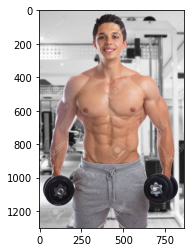

In [8]:
image = cv2.imread(upload('IMAGE:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Step 1-2: Upload `SOURCE_POINTS_FILE`

In [9]:
pts1 = np.loadtxt(upload('SOURCE_POINTS_FILE:')) # Use laptop_screen.txt for testing
print(pts1)

SOURCE_POINTS_FILE:


Saving before_squat_training.txt to before_squat_training.txt
[[  90.  409.]
 [ 791.  409.]
 [ 225. 1193.]
 [ 650. 1193.]]


## Step 1-3:  TARGET_POINTS_FILE

In [10]:
pts2 = np.loadtxt(upload('TARGET_POINTS_FILE:')) # Use laptop_rect.txt for testing
print(pts2)

TARGET_POINTS_FILE:


Saving after_squat_training.txt to after_squat_training.txt
[[ 141.  519.]
 [ 741.  519.]
 [ 174. 1183.]
 [ 680. 1183.]]


## Step 1-4: Rectify

new bb_min:
-126
302
new bb_max:
964
1316
New Image Size:
1090
1014
Vibrant c o l o r s !
shape of flattened(Pre-Mask)
(1105260,)
(1105260,)
mask
[False False False ... False False False]
(1105260,)
shape of x/y coordinates
(878645,)
(878645,)
shape/elements of flattened
(878645,)
(878645,)
[  0   0   1 ... 862 863 864]
[   0    0    0 ... 1298 1298 1298]
Shape of the picture
(1014, 1090, 3)


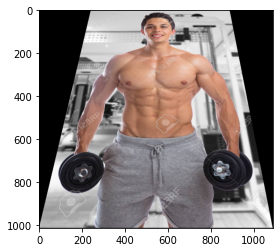

In [11]:
rectified = rectify(image, pts1, pts2).astype(np.uint8)
plt.imshow(cv2.cvtColor(rectified, cv2.COLOR_BGR2RGB))

# Just in case you want to download the output

#cv2.imwrite("rectified.png", rectified)
#files.download('rectified.png')

# 2. Composition

The function `composite()` below superimposes a region of a `source` image on top of a region of a `target` image. The source and the target regions are specified by corresponding points as done for `rectify()` above.

The function also takes a `mask` image which defines the transparency of `source`. This works as a stencil buffer if `mask` is a binary image, or as an alpha blending mask if grayscale.

In [0]:
"""Blends the source image with the target image according to the mask.
   Pixels with value "1" are source pixels, "0" are target pixels, and
   intermediate values are interpolated linearly between the two."""

def blend_with_mask(source, target, mask):
    # Creating another mask, this one for the target picture layer. 
    ones = np.ones(mask.shape)
    jimcarrey = ones - mask

    """Masks will be muliplied element-wise with the image ndarrays.
       Its values, which range from 0 to 1, determine the alpha value of 
       each pixels. """

    m_source = mask * source
    m_target = jimcarrey * target

    """Finally, two masked images are added. 
       Note that given the alpha of the mask at a given coordinae is x, 
       the alpha of the second mask is 1-x. 
       Thus adding the two layers gives the net alpha value of 1. """

    return m_source + m_target


In [0]:
 """Composites a masked planar region of the source image onto a
    corresponding planar region of the target image via homography warping.

    Only the source image (one that you are pasting) and its mask will be
    warped. The background (target) remains untouched."""
    
def composite(source, target, source_pts, target_pts, mask):

    # Compute the homography to warp points 
    # from the target to the source coordinate frame.
    h = compute_H(target_pts, source_pts)

    # Picture size of the target image 
    y_size, x_size, _ = target.shape
    canvas = [0,0,x_size, y_size]

    # Warp the images using the homography.
    warped = warp_homography(source, canvas, h)
    warped_mask = warp_homography(mask, canvas, h)
    
    # Blend the warped images.
    to_return = blend_with_mask(warped, target, warped_mask)

    blah("blender")

    return to_return


## Step 2-1: Upload `SOURCE` image

In [0]:
source = cv2.imread(upload('SOURCE:'), cv2.IMREAD_COLOR) # Use panda.png for testing
plt.imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))

## Step 2-2: Upload `TARGET` image

In [0]:
target = cv2.imread(upload('TARGET:'), cv2.IMREAD_COLOR) # Use laptop.jpg for testing
print(target.shape)
print(target[100])
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

## Step 2-3: Upload `SOURCE_POINTS` file

In [0]:
source_pts = np.loadtxt(upload('SOURCE_POINTS_FILE:')) # Use panda_point.txt for testing
print(source_pts)

## Step 2-4: Upload `TARGET_POINTS` file

In [0]:
target_pts = np.loadtxt(upload('TARGET_POINTS_FILE:')) # Use laptop_screen.txt for testing
print(target_pts)

## Step 2-5: Upload `MASK` image

In [0]:
mask = cv2.imread(upload('MASK:'), cv2.IMREAD_GRAYSCALE) # Use panda_mask.png for testing
plt.imshow(mask)
print(mask.shape)

mask = mask[:, :, np.newaxis]


## Step 2-6: Composite

In [0]:
composited = composite(source, target, source_pts, target_pts, mask/255).astype(np.uint8)
plt.imshow(cv2.cvtColor(composited, cv2.COLOR_BGR2RGB))
